# Table of Contents:
- [Reading csv](#Reading-csv)
- [Encoding features](#Encoding-features)
- [Features distribution](#Features-distribution)
  - [Check multivariate normality](#Check-multivariate-normality)
  - [Features distribution per class](#Features-distribution-per-class)
- [Missing values](#Missing-values)
- [Outliers detection](#Outliers-detection)
  - [Evaluating multidimensional outliers' class  label](#Evaluating-multidimensional-outliers'-class--label)
- [Feature - target split](#Feature---target-split)
- [Normalizing features](#Normalizing-features)
- [Train-test split](#Train-test-split)
- [Dimensionality reduction](#Dimensionality-reduction)
  - [Features correlation](#Features-correlation)
  - [mRMR feature selection algorithm](#mRMR-feature-selection-algorithm)
    - [mRMR selected features](#mRMR-selected-features)
  - [PCA](#PCA)
    - [Evaluate PCA explained variance](#Evaluate-PCA-explained-variance)
  - [KPCA](#KPCA)
    - [Cross validate KPCA hyperparameters](#Cross-validate-KPCA-hyperparameters)
    - [Evaluate KPCA](#Evaluate-KPCA)
- [Setup classifiers and grid search parameters](#Setup-classifiers-and-grid-search-parameters)
- [Cross validation pipeline](#Cross-validation-pipeline)
  - [Cross validation of models except ensemble ones](#Cross-validation-of-models-except-ensemble-ones)
  - [Ensemble cross validation with undersampling](#Ensemble-cross-validation-with-undersampling)
  - [Ensemble cross validation with oversampling](#Ensemble-cross-validation-with-oversampling)
  - [Best cross-validated pipelines](#Best-cross-validated-pipelines)
- [Plot results](#Plot-results)
  - [Best pipelines](#Best-pipelines)
  - [Tree pipelines](#Tree-pipelines)
  - [Features' importance](#Features'-importance)
  - [All best pipelines](#All-best-pipelines)

In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install plotly
# !pip install psutil
# !pip install category_encoders
# !pip install chart_studio
# !pip install numpy Cython
# !pip install -U pymrmr
# !pip install kfda
# !pip install pingouin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from scipy.spatial import distance
import category_encoders as ce
import os
import math
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import auc, accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, plot_confusion_matrix
from scipy.cluster import hierarchy as hc

# for mRMR implementation
import pymrmr

# for kfda implementation
from kfda import Kfda

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# multivariate normality test
from pingouin import multivariate_normality

import warnings
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=LinAlgWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

if not os.path.exists("./report/images"):
    os.mkdir("./report/images")
images_folder = "./report/images"

pd.set_option('display.max_columns', None) # prevents abbreviation (with '...') of columns in prints

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

SAVE_IMAGES = False
CROSS_VALIDATE = False
random_state = 42

In [3]:
def get_layout(title, height=1200, width=1100, y_title=None, x_title=None, barmode=None, showlegend=False, x_tickangle=0):
    return go.Layout(
    title=dict(text=title, xref="paper", x=0.5),
    autosize=True,
    width=width,
    height=height,
    margin=dict(t=50,l=10,b=10,r=10),
    showlegend=showlegend,
    yaxis=dict(
        title=y_title,
        automargin=True,
    ),
    xaxis=dict(
        title=x_title,
        tickangle=x_tickangle,
        automargin=True
    ),
    barmode=barmode,
)

def get_boxplot_trace(name, data, color = 'rgb(8,81,156)' , x=None, boxpoints='suspectedoutliers'):
    return go.Box(
        y=data,
        x=x,
        name=name,
        boxpoints=boxpoints,
        marker=dict(
        color=color,
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color=color) 

# Reading csv

In [4]:
# reading csv
df = pd.read_csv('../SouthGermanCredit/SouthGermanCredit.asc')

# small changes to dataset
df["credit_history"] = df["credit_history"].map(lambda x : x+1)
df["purpose"] = df["purpose"].map(lambda x : x+1)
df["installment_rate"] = df["installment_rate"].map(lambda x: 5-x)
df["credit_risk"] = df["credit_risk"].map(lambda x : 1-x) # inverting class labels

# print data stats
df.describe()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,3.54500,3.828000,3271.24800,2.105000,3.384000,2.027000,2.68200,1.145000,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.300000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,1.00000,1.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,3.00000,2.000000,1365.50000,1.000000,3.000000,1.000000,2.00000,1.000000,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,3.00000,3.000000,2319.50000,1.000000,3.000000,2.000000,3.00000,1.000000,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
75%,4.000000,24.000000,5.00000,4.000000,3972.25000,3.000000,5.000000,3.000000,3.00000,1.000000,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,5.00000,11.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


In [5]:
mappings = {1: "bad", 0:"good"}

y =  df["credit_risk"].value_counts()
data = [go.Bar(x=[mappings[x] for x in y.index], y=y.values, marker = dict(color = colors[:len(y.index)]))]
layout = get_layout("Credit risk", y_title='#samples', height=500, width=500)
fig = go.Figure(data=data, layout=layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/class.png")

# Encoding features

In [6]:
#binary encoding for "purpose" feature
encoder = ce.BinaryEncoder(cols=["purpose"], drop_invariant=True)
df_binary = encoder.fit_transform(df["purpose"])

# one-hot-enoding for the other categorical features with more than 2 labels
features = ["other_debtors", "other_installment_plans", "housing", "personal_status_sex"]
pre_df = pd.get_dummies(df, columns=features)
pre_df.drop("purpose", inplace=True, axis=1)
pre_df = pre_df.join(df_binary)

# other_debtors = 'none' is encoded with both other_debtors_1 and other_debtors_2 set to 0
pre_df.drop("other_debtors_1", inplace=True, axis=1)
pre_df.rename(columns={"other_debtors_2":"other_debtors_1", "other_debtors_3":"other_debtors_2"}, inplace=True)

# Trick to put the class feature as last column for convenience
pre_df = pre_df.join(pre_df.pop("credit_risk"))

pre_df.describe() 


,status,duration,credit_history,amount,savings,employment_duration,installment_rate,present_residence,property,age,number_credits,job,people_liable,telephone,foreign_worker,other_debtors_1,other_debtors_2,other_installment_plans_1,other_installment_plans_2,other_installment_plans_3,housing_1,housing_2,housing_3,personal_status_sex_1,personal_status_sex_2,personal_status_sex_3,personal_status_sex_4,purpose_1,purpose_2,purpose_3,purpose_4,credit_risk
count,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,3.54500,3271.24800,2.105000,3.384000,2.027000,2.845000,2.358000,35.54200,1.407000,2.904000,1.845000,1.404000,1.963000,0.041000,0.052000,0.13900,0.047000,0.814000,0.179000,0.714000,0.107000,0.050000,0.310000,0.54800,0.092000,0.071000,0.41700,0.374000,0.453000,0.300000
std,1.257638,12.058814,1.08312,2822.75176,1.580023,1.208306,1.118715,1.103718,1.050209,11.35267,0.577654,0.653614,0.362086,0.490943,0.188856,0.198389,0.222138,0.34612,0.211745,0.389301,0.383544,0.452115,0.309268,0.218054,0.462725,0.49794,0.289171,0.256953,0.49331,0.484106,0.498035,0.458487
min,1.000000,4.000000,1.00000,250.00000,1.000000,1.000000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,12.000000,3.00000,1365.50000,1.000000,3.000000,1.000000,2.000000,1.000000,27.00000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,18.000000,3.00000,2319.50000,1.000000,3.000000,2.000000,3.000000,2.000000,33.00000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,4.000000,24.000000,5.00000,3972.25000,3.000000,5.000000,3.000000,4.000000,3.000000,42.00000,2.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
max,4.000000,72.000000,5.00000,18424.00000,5.000000,5.000000,4.000000,4.000000,4.000000,75.00000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


# Features distribution

In [7]:
numerical_features = ["age", "duration", "amount"]
titles = tuple(df.keys()[0:-1])
layout = get_layout("Features' distributions")
fig = make_subplots(rows=5, cols=4, subplot_titles=titles, vertical_spacing=0.04, horizontal_spacing=0.04)
for index,feature in enumerate(titles):
    if feature not in numerical_features:
        y = df[feature].value_counts()
        fig.add_trace(go.Bar(x=[x for x in y.index], y=y.values, marker = dict(color = colors[0]), name=feature) ,row=index//4+1, col=index%4+1)
    else:
        trace = go.Histogram(x=df[feature], nbinsx=20, marker = dict(color = colors[0]), name=feature )
        fig.add_trace(trace ,row=index//4+1, col=index%4+1)
fig.update_layout(layout)
fig.show()     
if SAVE_IMAGES: 
    fig.write_image(f"{images_folder}/distributions.png")

In [8]:
numerical_features = ["age", "duration", "amount"]
titles = tuple(pre_df.keys()[0:-1])
rows = math.ceil(len(titles)/4)
layout = get_layout("Features distribution", height=1200/4*rows)
fig = make_subplots(rows=rows, cols=4, subplot_titles=titles, vertical_spacing=0.03, horizontal_spacing=0.04)
for index,feature in enumerate(titles):
    if feature not in numerical_features:
        y = pre_df[feature].value_counts()
        fig.add_trace(go.Bar(x=[x for x in y.index], y=y.values, marker = dict(color = colors[0])) ,row=index//4+1, col=index%4+1)
    else:
        trace = go.Histogram(x=pre_df[feature], nbinsx=20, marker = dict(color = colors[0]) )
        fig.add_trace(trace ,row=index//4+1, col=index%4+1)
fig.update_layout(layout)
fig.show()      
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/distributions_preprocessed.png")

## Check multivariate normality

In [9]:
#perform the Henze-Zirkler Multivariate Normality Test
df_check_normality = df_X = pre_df.drop(["credit_risk"], axis=1);
multivariate_normality(df_check_normality, alpha=.05)

HZResults(hz=4000, pval=0.0, normal=False)

## Features distribution per class

In [10]:
numerical_features = ["age", "duration", "amount"]
titles = tuple(df.keys()[0:-1])
layout = get_layout("Features distribution per class", barmode='overlay', showlegend=True)
fig = make_subplots(rows=5, cols=4, subplot_titles=titles, vertical_spacing=0.04, horizontal_spacing=0.04)
for index,feature in enumerate(titles):
    if feature not in numerical_features:
        feature_risk_df = df.groupby([feature, "credit_risk"]).size().unstack()
        fig.add_trace(go.Bar(x=feature_risk_df.index, y=feature_risk_df[0], marker = dict(color = colors[0]), legendgroup="good", showlegend=(feature==titles[0]),name="good"), row=index//4+1, col=index%4+1)
        fig.add_trace(go.Bar(x=feature_risk_df.index, y=feature_risk_df[1], marker = dict(color = colors[1]),legendgroup="bad", showlegend=(feature==titles[0]), name="bad",opacity=0.8), row=index//4+1, col=index%4+1)
    else:
        trace = go.Histogram(x=df[df["credit_risk"] == 0][feature], nbinsx=20, marker = dict(color = colors[0]),legendgroup="good", showlegend=False, name="good")
        fig.add_trace(trace ,row=index//4+1, col=index%4+1)
        trace = go.Histogram(x=df[df["credit_risk"] == 1][feature], nbinsx=20, marker = dict(color = colors[1]),legendgroup="bad", showlegend=False, name="bad", opacity=0.8)
        fig.add_trace(trace ,row=index//4+1, col=index%4+1)
fig.update_layout(layout)
fig.show()      
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/distributions_by_class.png")

# Missing values

In [11]:
print("There are " + ("some" if df.isnull().values.any() else "no")  + " missing values in the dataset.")

There are no missing values in the dataset.


# Outliers detection

In [12]:
titles = tuple(df.keys()[0:-1])
layout = get_layout("Box plots")
fig = make_subplots(rows=5, cols=4, subplot_titles = titles, vertical_spacing=0.04, horizontal_spacing=0.04)
for index,feature in enumerate(titles):
    fig.add_trace(get_boxplot_trace(feature, df[feature]) ,row=index//4+1, col=index%4+1)
fig.update_layout(layout)
fig.show()     
if SAVE_IMAGES:
    fig.write_image(f"{images_folder}/boxplots.png")
 

In [13]:
titles = ["duration", "amount", "age"]
label = "credit_risk"
cols = len(titles)
fig = make_subplots(rows=1, cols=cols, subplot_titles = titles, vertical_spacing=0.05)
layout = get_layout("Box Plots", height=400, width=1100)
for index,feature in enumerate(titles):
    fig.add_trace( get_boxplot_trace(feature, df[feature], color=colors[0]), row=1, col = index+1)
    
fig.update_layout(layout)
fig.show() 
   
if SAVE_IMAGES:
    # pio.write_image(fig, f"{images_folder}/significant_boxplots.png")
    fig.write_image(f"{images_folder}/significant_boxplots.png")

In [14]:
# boxplot with class

titles = ["duration", "amount", "age"]
label = "credit_risk"

cols = len(titles)
rows=1
fig = make_subplots(rows=rows, cols=cols, subplot_titles = titles, vertical_spacing=0.05)
layout = get_layout("Box plots with class", width=350*cols, height=500)
for index,feature in enumerate(titles):
    tmp_df = df[[feature, label]]
    fig.add_trace( get_boxplot_trace(feature, tmp_df[tmp_df[label] == 0][feature], x=np.repeat("good", 600), color=colors[0]), col=index+1, row=1)
    fig.add_trace( get_boxplot_trace(feature, tmp_df[tmp_df[label] == 1][feature], x=np.repeat("bad", 300), color=colors[1]), col=index+1, row=1)
   
fig.update_layout(layout)
fig.show() 
   
if SAVE_IMAGES:
    fig.write_image(f"{images_folder}/boxplots_with_classes.png")
 


In [15]:
titles = tuple(pre_df.keys()[0:-1])
rows = math.ceil(len(titles)/4)
fig = make_subplots(rows=rows, cols=4, subplot_titles = titles, vertical_spacing=0.025, horizontal_spacing=0.04)
layout = get_layout("Box plots", height=1200/5 * rows)
for index,feature in enumerate(titles):
    # print(f"row={index//4+1}, col={index%4+1}")
    fig.add_trace(get_boxplot_trace(feature, pre_df[feature]) ,row=index//4+1, col=index%4+1)
fig.update_layout(layout)
fig.show()     
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/boxplots_preprocessed.png")
 

In [16]:
mean = pre_df.mean()[:-1].values
data = np.array(pre_df)[:,:-1]
cov = np.cov(data.T)
icov = np.linalg.inv(cov)
m_distances = [distance.mahalanobis(sample, mean, icov) for sample in data]

layout = get_layout('Box plot of Mahalanobis distance', height=500, width = 500)
fig= go.Figure(get_boxplot_trace("Mahalanobis distance",m_distances), layout = layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/mahalanobis.png")

In [17]:
# violin plot of mahalanobis distance
layout=get_layout("Violin plot of Mahalanobis distance",height=500, width = 500)
fig= go.Figure(go.Violin(y=m_distances,
                        name="Mahalanobis distance",
                        box_visible=True,
                        meanline_visible=True
                    ), layout = layout
                )
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/mahalanobis_violin.png")

## Evaluating multidimensional outliers' class  label

In [18]:
mask = [True if distance >= 8.30 else False for distance in m_distances]
outliers = pre_df[mask]
print(outliers["credit_risk"])

323    0
645    0
711    0
754    1
935    1
976    1
977    1
Name: credit_risk, dtype: int64


# Feature - target split

In [19]:
df_y = pre_df["credit_risk"]
df_X = pre_df.drop(["credit_risk"], axis=1)

# Normalizing features

In [20]:
df_X_normalized  = (df_X - df_X.mean()) / (df_X.max() - df_X.min())
df_X_normalized.describe()

,status,duration,credit_history,amount,savings,employment_duration,installment_rate,present_residence,property,age,number_credits,job,people_liable,telephone,foreign_worker,other_debtors_1,other_debtors_2,other_installment_plans_1,other_installment_plans_2,other_installment_plans_3,housing_1,housing_2,housing_3,personal_status_sex_1,personal_status_sex_2,personal_status_sex_3,personal_status_sex_4,purpose_1,purpose_2,purpose_3,purpose_4
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,2.842171e-17,2.131628e-17,1.776357e-17,1.776357e-18,-2.486900e-17,8.881784e-18,-3.375078e-17,-7.016610e-17,-2.842171e-17,-3.019807e-17,-1.609823e-17,2.842171e-17,3.641532e-17,8.526513e-17,-7.815970e-17,8.881784e-19,-2.131628e-17,-1.509903e-17,-4.440892e-18,2.664535e-17,-1.154632e-17,2.842171e-17,0.000000,-7.105427e-18,-3.153033e-17,-4.263256e-17,2.664535e-18,1.421085e-17,-3.552714e-18,-3.907985e-17,-4.618528e-17
std,4.192126e-01,1.773355e-01,2.707799e-01,1.553181e-01,3.950057e-01,3.020766e-01,3.729049e-01,3.679060e-01,3.500697e-01,2.027263e-01,1.925515e-01,2.178713e-01,3.620858e-01,4.909430e-01,1.888562e-01,1.983894e-01,2.221381e-01,3.461196e-01,2.117447e-01,3.893014e-01,3.835441e-01,4.521155e-01,0.309268,2.180540e-01,4.627247e-01,4.979397e-01,2.891706e-01,2.569534e-01,4.933096e-01,4.841057e-01,4.980352e-01
min,-5.256667e-01,-2.485735e-01,-6.362500e-01,-1.662401e-01,-2.762500e-01,-5.960000e-01,-3.423333e-01,-6.150000e-01,-4.526667e-01,-2.953929e-01,-1.356667e-01,-6.346667e-01,-8.450000e-01,-4.040000e-01,-9.630000e-01,-4.100000e-02,-5.200000e-02,-1.390000e-01,-4.700000e-02,-8.140000e-01,-1.790000e-01,-7.140000e-01,-0.107000,-5.000000e-02,-3.100000e-01,-5.480000e-01,-9.200000e-02,-7.100000e-02,-4.170000e-01,-3.740000e-01,-4.530000e-01
25%,-5.256667e-01,-1.309265e-01,-1.362500e-01,-1.048612e-01,-2.762500e-01,-9.600000e-02,-3.423333e-01,-2.816667e-01,-4.526667e-01,-1.525357e-01,-1.356667e-01,3.200000e-02,1.550000e-01,-4.040000e-01,3.700000e-02,-4.100000e-02,-5.200000e-02,-1.390000e-01,-4.700000e-02,1.860000e-01,-1.790000e-01,-7.140000e-01,-0.107000,-5.000000e-02,-3.100000e-01,-5.480000e-01,-9.200000e-02,-7.100000e-02,-4.170000e-01,-3.740000e-01,-4.530000e-01
50%,-1.923333e-01,-4.269118e-02,-1.362500e-01,-5.236866e-02,-2.762500e-01,-9.600000e-02,-9.000000e-03,5.166667e-02,-1.193333e-01,-4.539286e-02,-1.356667e-01,3.200000e-02,1.550000e-01,-4.040000e-01,3.700000e-02,-4.100000e-02,-5.200000e-02,-1.390000e-01,-4.700000e-02,1.860000e-01,-1.790000e-01,2.860000e-01,-0.107000,-5.000000e-02,-3.100000e-01,4.520000e-01,-9.200000e-02,-7.100000e-02,-4.170000e-01,-3.740000e-01,-4.530000e-01
75%,4.743333e-01,4.554412e-02,3.637500e-01,3.857170e-02,2.237500e-01,4.040000e-01,3.243333e-01,3.850000e-01,2.140000e-01,1.153214e-01,1.976667e-01,3.200000e-02,1.550000e-01,5.960000e-01,3.700000e-02,-4.100000e-02,-5.200000e-02,-1.390000e-01,-4.700000e-02,1.860000e-01,-1.790000e-01,2.860000e-01,-0.107000,-5.000000e-02,6.900000e-01,4.520000e-01,-9.200000e-02,-7.100000e-02,5.830000e-01,6.260000e-01,5.470000e-01
max,4.743333e-01,7.514265e-01,3.637500e-01,8.337599e-01,7.237500e-01,4.040000e-01,6.576667e-01,3.850000e-01,5.473333e-01,7.046071e-01,8.643333e-01,3.653333e-01,1.550000e-01,5.960000e-01,3.700000e-02,9.590000e-01,9.480000e-01,8.610000e-01,9.530000e-01,1.860000e-01,8.210000e-01,2.860000e-01,0.893000,9.500000e-01,6.900000e-01,4.520000e-01,9.080000e-01,9.290000e-01,5.830000e-01,6.260000e-01,5.470000e-01


# Train-test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_X_normalized, df_y, test_size=0.20, random_state=random_state, stratify=df_y)

In [22]:
mappings = {1: "bad", 0:"good"}

y =  y_train.value_counts()
data = [go.Bar(x=[mappings[x] for x in y.index], y=y.values, marker = dict(color = colors[:len(y.index)]))]
layout = get_layout("Credit risk - training set", y_title='#samples', height=500, width=500)
fig = go.Figure(data=data, layout=layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/training_set.png")

y =  y_test.value_counts()
data = [go.Bar(x=[mappings[x] for x in y.index], y=y.values, marker = dict(color = colors[:len(y.index)]))]
layout = get_layout("Credit risk - test set", y_title='#samples', height=500, width=500)
fig = go.Figure(data=data, layout=layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/test_set.png")

# Dimensionality reduction

## Features correlation

In [23]:
correlation = df_X_normalized.corr()
layout = get_layout("Features correlation with Pearson", showlegend=True, width=1000, height=800, x_tickangle=40)
fig = go.Figure(data=go.Heatmap(
                   z=correlation,
                   x=df_X_normalized.keys(),
                   y=df_X_normalized.keys(),
                   colorscale='Viridis',
                   hoverongaps = False))
fig.update_layout(layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/correlation_pearson.png")

In [24]:
names = df_X_normalized.columns
inverse_correlation = 1 - abs(df_X_normalized.corr())
fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
layout = get_layout("Dendrogram of pairwise average distance (Pearson) ", width=850, height=600, x_title="distance", y_title="features")
fig.update_layout(layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/dendrogram_pearson.png")

In [25]:
correlation = df_X_normalized.corr(method="spearman")
layout = get_layout("Features correlation with Spearman", showlegend=True, width=1000, height=800, x_tickangle=40)
fig = go.Figure(data=go.Heatmap(
                   z=correlation,
                   x=df_X_normalized.keys(),
                   y=df_X_normalized.keys(),
                   colorscale='Viridis',
                   hoverongaps = False))
fig.update_layout(layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/correlation_spearman.png")

In [26]:
names = df_X_normalized.columns
inverse_correlation = 1 - abs(df_X_normalized.corr(method="spearman"))
fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
layout = get_layout("Dendrogram of pairwise average distance (Spearman) ", width=850, height=600, x_title="distance", y_title="features")
fig.update_layout(layout)
fig.show()
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/dendrogram_spearman.png")

## mRMR feature selection algorithm

implementation @ https://pypi.org/project/pymrmr/

ref: 
Hanchuan Peng, Fuhui Long, and Chris Ding, “Feature selection based on mutual information: criteria of max-dependency, max-relevance, and min-redundancy,” IEEE Transactions on Pattern Analysis and Machine Intelligence, Vol. 27, No. 8, pp.1226-1238, 2005.

In [27]:
'''
@param data : DataFrame where we want to apply feature selection on, with the class label in the first column
@param method : can be MIQ or MID
@param nfeatures : number of features we want to extract
@return the dataset with the selected features
'''
def apply_mRMR(data, method="MIQ", nfeatures=15):
    selected_features = pymrmr.mRMR(data, method, nfeatures)
    mrmr_miq_df = data[selected_features]
    return mrmr_miq_df, selected_features

### mRMR selected features

In [28]:
complete_df = X_train.copy(deep=True)
complete_df.insert(0, "class", y_train)
_, selected_features = apply_mRMR(complete_df, method="MIQ")
print(selected_features)

_, selected_features = apply_mRMR(complete_df, method="MID")
print(selected_features)

['personal_status_sex_1', 'personal_status_sex_2', 'other_installment_plans_2', 'other_installment_plans_3', 'housing_1', 'housing_2', 'housing_3', 'other_debtors_2', 'other_debtors_1', 'personal_status_sex_3', 'personal_status_sex_4', 'purpose_1', 'purpose_2', 'purpose_3', 'other_installment_plans_1']
['personal_status_sex_1', 'personal_status_sex_2', 'other_installment_plans_2', 'other_installment_plans_3', 'housing_1', 'housing_2', 'housing_3', 'other_debtors_2', 'other_debtors_1', 'personal_status_sex_3', 'personal_status_sex_4', 'purpose_1', 'purpose_2', 'purpose_3', 'other_installment_plans_1']


## PCA

In [29]:
def apply_PCA(data, n_components=15):
    pca = PCA(n_components = n_components, svd_solver = "full", random_state = random_state)
    pca_df = pca.fit_transform(data)
    # print(pca.n_components_)
    
    return pca_df, pca 

### Evaluate PCA explained variance

In [30]:
_ , result = apply_PCA(X_train, n_components=len(X_train.keys()))
total_explained = sum(result.explained_variance_) 
list_explained = [(i / total_explained) * 100 for i in sorted(result.explained_variance_, reverse=True)]
cumulative_explained = np.cumsum(list_explained) 

layout = get_layout("Scree plot", height=500, x_title="principal components", showlegend=True)
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=list(range(1, len(list_explained) + 1)),
        y=list_explained, 
        mode='lines+markers',
        name="explained variance"
        ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=list(range(1, len(cumulative_explained) + 1)),
        y=cumulative_explained,
        mode='lines+markers',
        name="cumulative explained variance",
        line=dict(
            shape='hv',
        )
    ),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    layout
)

# Set y-axes titles
fig.update_yaxes(title_text="explained variance", secondary_y=False, range=[-0.72,15.72], tickmode="linear", tick0=0, dtick=3)
fig.update_yaxes(title_text="cumulative explained variance [%] ", secondary_y=True, showgrid = False, range=[-5,105], zeroline=False)

fig.show()

if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/scree_plot.png")

## KPCA

In [31]:
def apply_KPCA(data, n_components=15, kernel="poly", degree=5, gamma=0.001, coef0=10):
    pca = KernelPCA(n_components = n_components, kernel=kernel, random_state = random_state, degree=degree, gamma=gamma, coef0=coef0)
    pca_df = pca.fit_transform(data)
    # print(pca.n_components_)
    
    return pca_df, pca 

### Cross validate KPCA hyperparameters

In [32]:
if(CROSS_VALIDATE):
    def kpca_scorer(estimator, X, y=None):
        X_reduced = estimator.transform(X)
        X_preimage = estimator.inverse_transform(X_reduced)
        return -1 * mean_squared_error(X, X_preimage)
        # reconstruction error multiplied by -1 because the objective is to minimize it

    param_grid = {
                "poly":[{"degree": [3, 5, 7, 9], "gamma": [0.001, 0.01, 0.03, 0.05 ], "coef0": [0.1, 1, 5, 10, 15, 20]}],
                "rbf":[{"gamma": [0.01, 0.1, 1, 5, 10]}],
                "sigmoid":[{"gamma": [0.1, 0.2, 0.3, 0.4], "coef0": [0.001, 0.01, 0.1, 1, 5, 10]}],
                "cosine":[{}]
                    }

    for kernel in ["poly", "rbf", "sigmoid", "cosine"]:
        print("\t",kernel)
        kpca=KernelPCA(fit_inverse_transform=True, n_jobs=-1, n_components=len(X_train.keys()), kernel = kernel) 
        grid_search = GridSearchCV(kpca, param_grid[kernel], cv=3, scoring=kpca_scorer)
        grid_search.fit(X_train)
        print("\t\t", grid_search.best_score_)
        print("\t\t", grid_search.best_estimator_)

### Evaluate KPCA

In [33]:
kernels =["poly", "rbf", "sigmoid", "cosine"]
titles = kernels
params = {
    "poly":{"degree":5, "gamma": 0.001, "coef0":10},
    "rbf":{"degree":None, "gamma": 0.1, "coef0":None},
    "sigmoid":{"degree":None, "gamma": 0.1, "coef0": 0.001},
    "cosine":{"degree":None, "gamma": None, "coef0": None}
}
layout = get_layout("Features distribution per class", barmode='overlay', showlegend=True)
layout = get_layout(f"Scree plots of KPCA", height=800, width=1200, showlegend=True)
fig = make_subplots(rows=2, cols=2, specs=[[{"secondary_y": True}, {"secondary_y": True}], [{"secondary_y": True}, {"secondary_y": True}]], \
    subplot_titles=titles, vertical_spacing=0.1, horizontal_spacing=0.1)
for index,kernel in enumerate(titles):
    _ , result = apply_KPCA(X_train, n_components=len(X_train.keys()), kernel=kernel,\
         gamma=params[kernel]["gamma"], degree=params[kernel]["degree"], coef0=params[kernel]["coef0"])
    total_explained = sum(result.lambdas_) 
    list_explained = [(i / total_explained) * 100 for i in sorted(result.lambdas_, reverse=True)]
    cumulative_explained = np.cumsum(list_explained) 

    # Add traces
    trace = go.Scatter(
            x=list(range(1, len(list_explained) + 1)),
            y=list_explained, 
            mode='lines+markers',
            name="explained variance",
            legendgroup="explained variance",
            showlegend=(kernel=="poly"),
            marker = dict(color = colors[0])
            )
    fig.add_trace(
        trace,
        secondary_y=False,
        row=index//2+1,
        col=index%2+1
    )

    trace=go.Scatter(
            x=list(range(1, len(cumulative_explained) + 1)),
            y=cumulative_explained,
            mode='lines+markers',
            name="cumulative explained variance",
            legendgroup="cumulative explained variance",
            showlegend=(kernel=="poly"),
            marker = dict(color = colors[1]),
            line=dict(
                shape='hv',
            )
        )

    fig.add_trace(
        trace,
        secondary_y=True,
        row=index//2+1,
        col=index%2+1
    )

    # Set y-axes titles
    fig.update_yaxes(title_text="explained variance", secondary_y=False, range=[-0.72,15.72], tickmode="linear", tick0=0, dtick=3)
    fig.update_yaxes(title_text="cumulative explained variance [%] ", secondary_y=True, showgrid = False, range=[-5,105], zeroline=False)

    # Set x-axis title
    fig.update_xaxes(title_text="principal components",)
    
fig.update_layout(layout)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.2,
    xanchor="right",
    x=0.9
))
fig.show()      
if SAVE_IMAGES:
    pio.write_image(fig, f"{images_folder}/scree_plot_kpca.png")


# Setup classifiers and grid search parameters

In [34]:

classifiers = {
    "DecisionTreeClassifier":  DecisionTreeClassifier(random_state=random_state),
    "DecisionTreeClassifierWithPruning": DecisionTreeClassifier(random_state=random_state),
    "LogisticRegression": LogisticRegression(random_state=random_state, solver="liblinear"),
    "SupportVectorMachine": SVC(random_state=random_state),
    "KNN": KNeighborsClassifier(),
    "FisherDiscriminantAnalysis": Kfda(n_components=1),
}

classifiers_params = {
    "DecisionTreeClassifier": {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': np.arange(1,31,5).tolist(),
        'classifier__min_samples_split': [0.001, 0.01, 0.1, 0.25, 0.45],
        'classifier__min_samples_leaf': [0.001, 0.01, 0.1, 0.25, 0.45]
    },
    "DecisionTreeClassifierWithPruning": {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__ccp_alpha': [0.0, 0.005, 0.001, 0.01, 0.015, 0.02, 0.025, 0.03, 0.05]
    },
    "LogisticRegression":{
        'classifier__penalty': ['l1', 'l2'], 
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    "SupportVectorMachine": {
        'classifier__C': [0.1, 1, 10, 100], 
        "classifier__kernel":["linear","poly", "rbf", "sigmoid"],
        "classifier__degree":[3,5,7,10],
        "classifier__gamma":[0.001, 0.01, 0.1, 1],
        "classifier__coef0":[0.0, 0.001, 0.1, 1, 3, 5]        
    },
    "KNN": {
        'classifier__n_neighbors': np.arange(1,15,2).tolist(), 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__p': [1, 2],
    },
    "FisherDiscriminantAnalysis": {
        "classifier__kernel":["linear","poly", "rbf", "sigmoid"]
    }
}

ensemble_classifiers_params={
    "BaggingClassifier":{
        "classifier__max_samples":[0.25, 0.5, 0.75, 1.0],
        "classifier__n_estimators":[10, 100, 1000]
    },
    "BaggingClassifierWithPruning":{
        "classifier__max_samples":[0.25, 0.5, 0.75, 1.0],
        "classifier__n_estimators":[10, 100, 1000]
    },
    "RandomForestClassifier":{
        "classifier__n_estimators":[10, 100, 1000]
    },
    "RandomForestClassifierWithPruning":{
        "classifier__n_estimators":[10, 100, 1000]
    }
}



# Cross validation pipeline

In [35]:
def apply_kfold_cross_validation(algorithm, params, X_train, y_train):

    complete_df = X_train.copy(deep=True)
    complete_df.insert(0, "class", y_train)

    pca_df, _ = apply_PCA(X_train)
    kpca_df, _ = apply_KPCA(X_train)
    mRMR_MIQ_df, _ = apply_mRMR(complete_df, method="MIQ")
    mRMR_MID_df, _ = apply_mRMR(complete_df, method="MID")
    dim_reduction_methods = {
        "PCA":pca_df, 
        "KPCA": kpca_df,
        "mRMR_MIQ":mRMR_MIQ_df, 
        "mRMR_MID":mRMR_MID_df,
        "none": X_train
        }
    balancing_dataset_methods = {
        "undersampling": RandomUnderSampler(random_state=random_state), 
        "oversampling": RandomOverSampler(random_state=random_state)
    }

    for dim_reduction_method in dim_reduction_methods.keys():
        print("\t",dim_reduction_method)
        for balancing_method in balancing_dataset_methods.keys():
            print("\t\t",balancing_method)
            
            pipeline = Pipeline([("balancing",balancing_dataset_methods[balancing_method]),("classifier",algorithm)])
  
            kf_total = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
            gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=1, cv=kf_total, scoring='f1')
            gs.fit(dim_reduction_methods[dim_reduction_method], y_train)
        
            print("\t\t\t",gs.best_score_)
            print("\t\t\t",gs.best_params_)


## Cross validation of models except ensemble ones

In [36]:
if(CROSS_VALIDATE):
    for classifier_name, classifier  in classifiers.items():
        print(classifier_name)
        apply_kfold_cross_validation(classifier, classifiers_params[classifier_name], X_train, y_train)

## Ensemble cross validation with undersampling

In [37]:
if(CROSS_VALIDATE):
    balancing_methods = {
            "BaggingClassifier": RandomUnderSampler(random_state=random_state),
            "BaggingClassifierWithPruning": RandomUnderSampler(random_state=random_state),
            "RandomForestClassifier" : RandomUnderSampler(random_state=random_state),
            "RandomForestClassifierWithPruning" : RandomUnderSampler(random_state=random_state)
            }
    ensemble_classifiers={
        "BaggingClassifier": BaggingClassifier(random_state=random_state, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001)),
        "BaggingClassifierWithPruning": BaggingClassifier(random_state=random_state, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.025)),
        "RandomForestClassifier": RandomForestClassifier(random_state=random_state, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001),
        "RandomForestClassifierWithPruning": RandomForestClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.025),
    }
    for classifier_name, classifier  in ensemble_classifiers.items():
        print("\t",classifier_name)
        
        pipeline = Pipeline([("balancing",balancing_methods[classifier_name]),("classifier",classifier)])

        kf_total = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        gs = GridSearchCV(estimator=pipeline, param_grid=ensemble_classifiers_params[classifier_name], n_jobs=1, cv=kf_total, scoring='f1')
        gs.fit(X_train, y_train)

        print("\t\t",gs.best_score_)
        print("\t\t",gs.best_params_)

## Ensemble cross validation with oversampling

In [38]:
if(CROSS_VALIDATE):
    balancing_methods = {
            "BaggingClassifier": RandomOverSampler(random_state=random_state),
            "BaggingClassifierWithPruning": RandomOverSampler(random_state=random_state),
            "RandomForestClassifier" : RandomOverSampler(random_state=random_state),
            "RandomForestClassifierWithPruning" : RandomOverSampler(random_state=random_state)
            }
    ensemble_classifiers={
        "BaggingClassifier": BaggingClassifier(random_state=random_state, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)),
        "BaggingClassifierWithPruning": BaggingClassifier(random_state=random_state, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02)),
        "RandomForestClassifier": RandomForestClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45),
        "RandomForestClassifierWithPruning": RandomForestClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02),
    }
    for classifier_name, classifier  in ensemble_classifiers.items():
        print("\t",classifier_name)
        
        pipeline = Pipeline([("balancing",balancing_methods[classifier_name]),("classifier",classifier)])

        kf_total = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        gs = GridSearchCV(estimator=pipeline, param_grid=ensemble_classifiers_params[classifier_name], n_jobs=1, cv=kf_total, scoring='f1')
        gs.fit(X_train, y_train)

        print("\t\t",gs.best_score_)
        print("\t\t",gs.best_params_)

## Best cross-validated pipelines

In [39]:
tree_pipelines = {
    "DecisionTreeClassifier": {
        "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001),
        "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)
        
    },
    "DecisionTreeClassifierWithPruning": {

        "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.025),
        "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02)
  
    },
     "BaggingClassifier":{
    
        "undersampling": BaggingClassifier(random_state=random_state, n_estimators=100, max_samples=0.25, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001)),
        "oversampling": BaggingClassifier(random_state=random_state, n_estimators=10, max_samples=0.75, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)),
          
    },
    "BaggingClassifierWithPruning":{

        "undersampling": BaggingClassifier(random_state=random_state, n_estimators=1000, max_samples=0.25, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.025)),
        "oversampling": BaggingClassifier(random_state=random_state, n_estimators=1000, max_samples=0.25, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02)),
       
    },
    "RandomForestClassifier":{
     
        "undersampling": RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001),
        "oversampling": RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45),
         
    },
    "RandomForestClassifierWithPruning":{
   
        "undersampling": RandomForestClassifier(random_state=random_state, n_estimators=1000, criterion="gini", ccp_alpha=0.025),
        "oversampling": RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="entropy", ccp_alpha=0.02),
           
    },
}

pipelines = {
    "DecisionTreeClassifier": {
        "PCA":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", max_depth=11, min_samples_leaf=0.001, min_samples_split=0.25),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)
            }, 
        "KPCA": {
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", max_depth=6, min_samples_leaf=0.1, min_samples_split=0.45)
            },
        "mRMR_MIQ":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.1, min_samples_split=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.1, min_samples_split=0.001)
            }, 
        "mRMR_MID":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.1, min_samples_split=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.1, min_samples_split=0.001)
            },
        "none": {
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)
            }
    },
    "DecisionTreeClassifierWithPruning": {
        "PCA":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.015),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.01)
            }, 
        "KPCA": {
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.005),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.01)
            },
        "mRMR_MIQ":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.001)
            }, 
        "mRMR_MID":{
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.001),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.001)
            },
        "none": {
            "undersampling": DecisionTreeClassifier(random_state=random_state, criterion="gini", ccp_alpha=0.025),
            "oversampling": DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02)
            }
    },
    "LogisticRegression":
        {
        "PCA":{
            "undersampling": LogisticRegression(random_state=random_state, solver="liblinear", C=1, penalty="l2"),
            "oversampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.1, penalty="l1")
            }, 
        "KPCA": {
            "undersampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.1, penalty="l1"),
            "oversampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.01, penalty="l1")
            },
        "mRMR_MIQ":{
            "undersampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.001, penalty="l2"),
            "oversampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.1, penalty="l2")
            }, 
        "mRMR_MID":{
            "undersampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.001, penalty="l2"),
            "oversampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.1, penalty="l2")
            },
        "none": {
            "undersampling": LogisticRegression(random_state=random_state, solver="liblinear", C=1, penalty="l1"),
            "oversampling": LogisticRegression(random_state=random_state, solver="liblinear", C=0.1, penalty="l2")
            }
        },
    "SupportVectorMachine": {
        "PCA":{
            "undersampling": SVC(random_state=random_state, C=1, kernel="sigmoid", gamma=0.1, coef0=0.1),
            "oversampling": SVC(random_state=random_state, C=1, kernel="poly", gamma=0.001, coef0=3, degree=3)
            }, 
        "KPCA": {
            "undersampling": SVC(random_state=random_state, C=100, kernel="sigmoid", gamma=0.001, coef0=0.0),
            "oversampling": SVC(random_state=random_state, C=1, kernel="sigmoid", gamma=0.001, coef0=1)
            },
        "mRMR_MIQ":{
            "undersampling": SVC(random_state=random_state, C=0.1, kernel="rbf", gamma=1),
            "oversampling": SVC(random_state=random_state, C=0.1, kernel="poly", gamma=0.001, coef0=5, degree=10)
            }, 
        "mRMR_MID":{
            "undersampling": SVC(random_state=random_state, C=0.1, kernel="rbf", gamma=1),
            "oversampling": SVC(random_state=random_state, C=0.1, kernel="poly", gamma=0.001, coef0=5, degree=10)
            },
        "none": {
            "undersampling": SVC(random_state=random_state, C=1, kernel="sigmoid", gamma=0.1, coef0=0.1),
            "oversampling": SVC(random_state=random_state, C=1, kernel="poly", gamma=0.01, coef0=1, degree=5)
            }
    },
    "FisherDiscriminantAnalysis": {
        "PCA":{
            "undersampling": Kfda(n_components=1, kernel="linear"),
            "oversampling": Kfda(n_components=1, kernel="linear")
            }, 
        "KPCA": {
            "undersampling": Kfda(n_components=1, kernel="linear"),
            "oversampling": Kfda(n_components=1, kernel="sigmoid")
            },
        "mRMR_MIQ":{
            "undersampling": Kfda(n_components=1, kernel="linear"),
            "oversampling": Kfda(n_components=1, kernel="linear")
            }, 
        "mRMR_MID":{
            "undersampling": Kfda(n_components=1, kernel="linear"),
            "oversampling": Kfda(n_components=1, kernel="linear")
            },
        "none": {
            "undersampling": Kfda(n_components=1, kernel="linear"),
            "oversampling": Kfda(n_components=1, kernel="linear")
            }
    },
    "KNN": {
        "PCA":{
            "undersampling": KNeighborsClassifier(n_neighbors=13, p=2, weights="uniform"),
            "oversampling": KNeighborsClassifier(n_neighbors=11, p=1, weights="distance")
            }, 
        "KPCA": {
            "undersampling": KNeighborsClassifier(n_neighbors=13, p=2, weights="uniform"),
            "oversampling": KNeighborsClassifier(n_neighbors=11, p=1, weights="distance")
            },
        "mRMR_MIQ":{
            "undersampling": KNeighborsClassifier(n_neighbors=13, p=1, weights="distance"),
            "oversampling": KNeighborsClassifier(n_neighbors=13, p=1, weights="uniform")
            }, 
        "mRMR_MID":{
            "undersampling": KNeighborsClassifier(n_neighbors=13, p=1, weights="distance"),
            "oversampling": KNeighborsClassifier(n_neighbors=13, p=1, weights="uniform")
            },
        "none": {
            "undersampling": KNeighborsClassifier(n_neighbors=13, p=1, weights="distance"),
            "oversampling": KNeighborsClassifier(n_neighbors=7, p=2, weights="distance")
            }
    },
    
}

best_pipelines = {
    "DecisionTreeClassifier": {
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45))
            ])
    },
    "DecisionTreeClassifierWithPruning": {
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02))
            ])
    },
    "BaggingClassifier":{
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', BaggingClassifier(random_state=random_state, n_estimators=10, max_samples=0.75, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=6, min_samples_leaf=0.001, min_samples_split=0.45)))
            ])
    },
    "BaggingClassifierWithPruning":{
         "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', BaggingClassifier(random_state=random_state, n_estimators=1000, max_samples=0.25, base_estimator=DecisionTreeClassifier(random_state=random_state, criterion="entropy", ccp_alpha=0.02)))
            ])
    },
    "RandomForestClassifier":{
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomUnderSampler(random_state=random_state)),
            ('classifier', RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="gini", max_depth=1, min_samples_leaf=0.001, min_samples_split=0.001))
            ])
    },
    "RandomForestClassifierWithPruning":{
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="entropy", ccp_alpha=0.02))
            ])
    },
    "SupportVectorMachine": { 
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', SVC(random_state=random_state, C=1, kernel="poly", gamma=0.01, coef0=1, degree=5))
            ])
    },
    "LogisticRegression": { 
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomUnderSampler(random_state=random_state)),
            ('classifier', LogisticRegression(random_state=random_state, solver="liblinear", C=1, penalty="l1"))
            ])
    },
    "KNN": { 
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomUnderSampler(random_state=random_state)),
            ('classifier', KNeighborsClassifier(n_neighbors=13, p=1, weights="distance"))
            ])
    },
    "FisherDiscriminantAnalysis": { 
        "dim_reduction" : "none",
        "pipeline" : Pipeline(steps=[
            ('balancing', RandomOverSampler(random_state=random_state)),
            ('classifier', Kfda(n_components=1, kernel="linear"))
            ])
    }
}

# Plot results

In [40]:
complete_df = X_train.copy(deep=True)
complete_df.insert(0, "class", y_train)

pca_df , pca = apply_PCA(X_train)
kpca_df , kpca = apply_KPCA(X_train)
mRMR_MIQ_df , mRMR_MIQ_features = apply_mRMR(complete_df, method="MIQ")
mRMR_MID_df , mRMR_MID_features = apply_mRMR(complete_df, method="MID")

train_dfs = {
        "PCA": pca_df,
        "KPCA": kpca_df,
        "mRMR_MIQ": mRMR_MIQ_df, 
        "mRMR_MID": mRMR_MID_df,
        "none": X_train
} 

test_dfs = {
        "PCA": pca.transform(X_test), 
        "KPCA": kpca.transform(X_test),
        "mRMR_MIQ": X_test[mRMR_MIQ_features], 
        "mRMR_MID": X_test[mRMR_MID_features],
        "none": X_test
}  


## Best pipelines

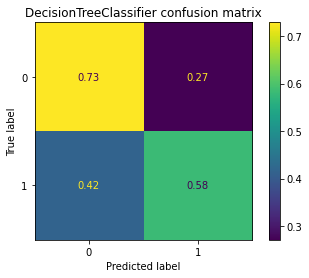

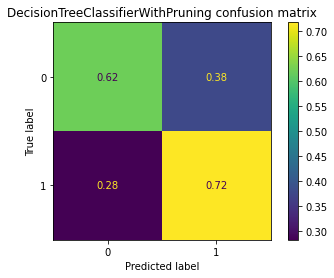

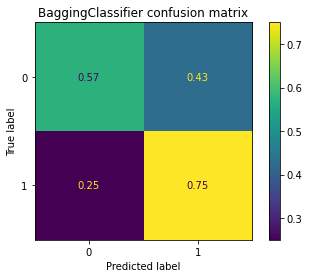

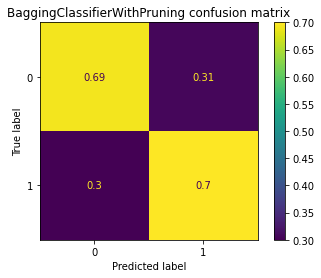

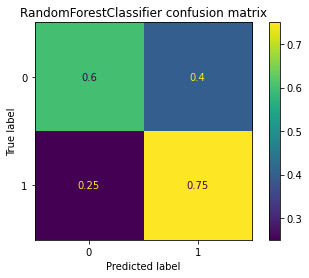

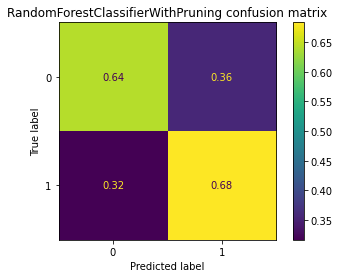

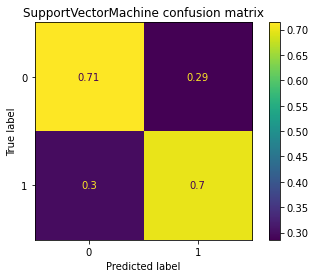

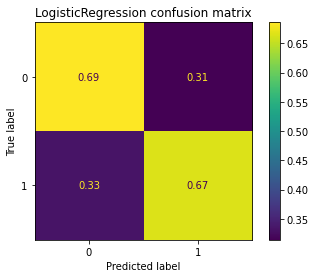

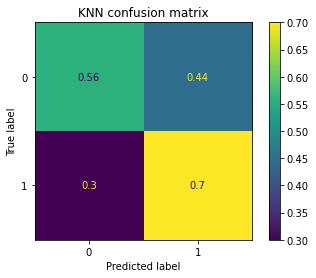

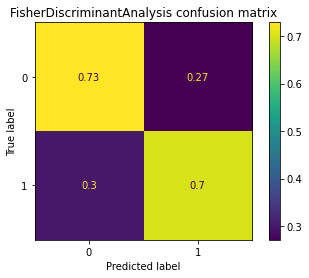

,accuracy,precision,recall,f1
DecisionTreeClassifier,0.685,0.479,0.583,0.526
DecisionTreeClassifierWithPruning,0.650,0.448,0.717,0.551
BaggingClassifier,0.625,0.429,0.750,0.545
BaggingClassifierWithPruning,0.695,0.494,0.700,0.579
RandomForestClassifier,0.645,0.446,0.750,0.559
RandomForestClassifierWithPruning,0.655,0.451,0.683,0.543
SupportVectorMachine,0.710,0.512,0.700,0.592
LogisticRegression,0.680,0.476,0.667,0.556
KNN,0.600,0.404,0.700,0.512
FisherDiscriminantAnalysis,0.720,0.525,0.700,0.600


In [41]:
models_names = []
f1s = []
accuracies = []
recalls = []
precisions = []
for algorithm, pipeline in best_pipelines.items():
        train_df = train_dfs[pipeline["dim_reduction"]]
        test_df = test_dfs[pipeline["dim_reduction"]] 

        model = pipeline["pipeline"].fit(train_df, y_train)
        y_pred = model.predict(test_df)

        models_names.append(algorithm)
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))

        plot_confusion_matrix(model, test_df, y_test, normalize='true')
        plt.title(f"{algorithm} confusion matrix")
        if(SAVE_IMAGES):
            plt.savefig(f"{images_folder}/confusion_{algorithm}.png")
        plt.show()

results_df = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], )
for (i,name) in enumerate(models_names):
    row = []
    row.append(accuracies[i])
    row.append(precisions[i])
    row.append(recalls[i])
    row.append(f1s[i])
    row = ["%.3f" % r for r in row]
    results_df.loc[name] = row

results_df


## Tree pipelines

In [42]:
for (balancing_name, balancing_method) in zip(["undersampling", "oversampling"],[RandomUnderSampler(random_state=random_state), RandomOverSampler(random_state=random_state)]):
    models_names = []
    f1s = []
    for algorithm, classifier in tree_pipelines.items():
        train_df = train_dfs["none"]
        test_df = test_dfs["none"] 

        pipeline = Pipeline(steps=[
        ('balancing', balancing_method), ('classifier', classifier[balancing_name])
        ])
        model = pipeline.fit(train_df, y_train)
        y_pred = model.predict(test_df)

        models_names.append(algorithm)  
        f1s.append(f1_score(y_test, y_pred))

    data = [go.Bar(name=name, x=[""], y=[f1]) for (name,f1) in zip(models_names, f1s)]
    fig = go.Figure(data = data)
    layout = get_layout(f"Tree-based models F1 with {balancing_name}", barmode="group", showlegend=True, height=400, width=500)
    fig.update_layout(layout)
    fig.update_layout(legend=dict(
        yanchor="bottom",
        y=0.05,
        xanchor="right",
        x=0.99
    ))
    fig.show()
    if(SAVE_IMAGES):
        pio.write_image(fig, f"{images_folder}/trees_{balancing_name}.png")    

## Features' importance

In [43]:
for name in ["DecisionTreeClassifier", "DecisionTreeClassifierWithPruning"]:
    pipeline = best_pipelines[name]["pipeline"]
    pipeline.fit(X_train, y_train)
    feature_importance = np.array(sorted(zip(X_train.columns, pipeline["classifier"].feature_importances_), key=lambda x: x[1], reverse=True))
    data = [go.Bar(
        x=feature_importance[:, 0],
        y=feature_importance[:, 1],
        marker = dict(color = colors[0]),
        name='feature importance'
    )]
    layout = get_layout(f"{name} features importance", y_title="feature importance", x_tickangle=40, height=400, width=800) 
    fig = go.Figure(data=data, layout=layout)
    fig.show()
    if(SAVE_IMAGES):
        pio.write_image(fig, f"{images_folder}/{name}_features_importance.png") 

## All best pipelines

In [44]:
models_names = list(pipelines.keys())
for (balancing_name, balancing_method) in zip(["undersampling", "oversampling"],[RandomUnderSampler(random_state=random_state), RandomOverSampler(random_state=random_state)]):
    data_accuracies = []
    data_f1s = []
    for dim_reduction in train_dfs.keys():

        train_df = train_dfs[dim_reduction]
        test_df = test_dfs[dim_reduction] 

        f1s = []
        accuracies = []

        for algorithm in pipelines.keys():

            classifier = pipelines[algorithm][dim_reduction][balancing_name]
            pipeline = Pipeline(steps=[
            ('balancing', balancing_method), ('classifier', classifier)
            ])
            model = pipeline.fit(train_df, y_train)
            y_pred = model.predict(test_df)
  
            f1s.append(f1_score(y_test, y_pred))
            accuracies.append(accuracy_score(y_test, y_pred))
        
        data_accuracies.append(go.Bar(name=dim_reduction, x=models_names, y=accuracies))
        data_f1s.append(go.Bar(name=dim_reduction, x=models_names, y=f1s))

    fig = go.Figure(data = data_accuracies)
    layout = get_layout(f"Models accuracy with {balancing_name}", barmode="group", showlegend=True, height=400, width=600, x_tickangle=15)
    fig.update_layout(layout)
    fig.update_layout(legend=dict(
        yanchor="bottom",
        y=0.05,
        xanchor="right",
        x=0.99
    ))
    fig.show()
    if(SAVE_IMAGES):
        pio.write_image(fig, f"{images_folder}/models_accuracy_with_{balancing_name}.png")   

    fig = go.Figure(data = data_f1s)
    layout = get_layout(f"Models F1 with {balancing_name}", barmode="group", showlegend=True, height=400, width=600, x_tickangle=15)
    fig.update_layout(layout)
    fig.update_layout(legend=dict(
        yanchor="bottom",
        y=0.05,
        xanchor="right",
        x=0.99
    ))
    fig.show()
    if(SAVE_IMAGES):
        pio.write_image(fig, f"{images_folder}/models_f1_with_{balancing_name}.png") 